In [23]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.optimize import minimize
%matplotlib inline
plt.style.use('ggplot')

## Movie data

In [24]:
data = scipy.io.loadmat('ex8_movies.mat')
Y = data['Y']
R = data['R'].astype(bool)
print Y.shape, R.shape

(1682, 943) (1682, 943)


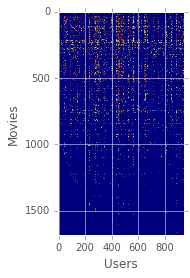

In [25]:
plt.figure()
plt.imshow(Y, aspect='equal', origin='upper')#, extent=(0, Y.shape[1], 0, Y.shape[0]/2.0))
plt.ylabel('Movies')
plt.xlabel('Users')

In [26]:
#  Load pre-trained weights (X, Theta, num_users, num_movies, num_features)
data = scipy.io.loadmat('ex8_movieParams.mat')
# X[i]: feature vector for movie i
X = data['X']
# theta[i] = parameter vector for user i
Theta = data['Theta']
num_users = data['num_users']
num_movies = data['num_movies']
num_features = data['num_features']

#  Reduce the data set size so that this runs faster
num_users = 4
num_movies = 5
num_features = 3
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]
print "X:",X.shape,"theta:", Theta.shape, "Y:", Y.shape,"R:", R.shape

print 'Average rating for movie 1: %f / 5' % np.mean(Y[0, R[0, :]])

X: (5, 3) theta: (4, 3) Y: (5, 4) R: (5, 4)
Average rating for movie 1: 4.500000 / 5


## Cost function

In [29]:
# J, grad = cf_cost_func(
#     np.hstack((X.T.flatten(), Theta.T.flatten())),
#     Y,
#     R,
#     num_users,
#     num_movies,
#     num_features,
#     0)
           
def cf_cost_func(params, Y, R, num_users, num_movies, num_features, Lambda):

    # Unfold the U and W matrices from params
    X = np.array(params[:num_movies*num_features]).reshape(num_features, num_movies).T.copy()
    Theta = np.array(params[num_movies*num_features:]).reshape(num_features, num_users).T.copy()


    # You need to return the following values correctly
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    
    # rating for movie i by user j : y(i,j) = theta(j)^T * x(i)
    
    J = 0.5 * np.sum(((np.dot(X,Theta.T)-Y)[R==1])**2)
    X_grad = np.dot((np.dot(X,Theta.T)-Y), Theta)
    Theta_grad = np.dot((np.dot(X,Theta.T)-Y).T,X)
    grad = np.hstack((X_grad.T.flatten(),Theta_grad.T.flatten()))

    return J, grad



J, grad = cf_cost_func(np.hstack((X.T.flatten(), Theta.T.flatten())), Y, R, num_users, num_movies,
               num_features, 0)
           
print 'Cost at loaded parameters: %f \n(this value should be about 22.22)' % J
print grad

Cost at loaded parameters: 22.224604 
(this value should be about 22.22)
[ -1.93247445e+00   2.93395092e-01  -9.02973274e-02   2.56592386e-01
   9.63440309e-02   6.87326212e+00   2.65069230e+00   4.54409337e+00
   1.32055068e+00   4.35856206e+00  -8.52095298e-01   2.30302729e-01
  -4.73375545e-01   8.01668172e-01  -4.42816654e-01  -1.05680202e+01
  -1.25306693e+00   1.16304270e+00   3.43544703e+00   4.62776019e+00
  -8.45966785e-03  -9.91160128e-01  -1.68835487e+00  -7.16004443e+00
  -2.39078622e+00   1.51839686e+00   2.70292228e+00]


## Normalize ratings

In [30]:
def normalizeRatings(Y, R):
    """normalized Y so that each movie has a rating of 0 on average,
    and returns the mean rating in Ymean.
    """

    m, n = Y.shape
    Ymean = np.zeros(m)
    Ynorm = np.zeros(Y.shape)

    for i in range(n):
        idx = (R[i,:]==1).nonzero()[0]
        if len(idx):
            Ymean[i] = np.mean(Y[i, idx])
            Ynorm[i, idx] = Y[i, idx] - Ymean[i]
        else:
            Ymean[i] = 0.0
            Ynorm[i,idx] = 0.0

    return Ynorm, Ymean

#  Normalize Ratings
Ynorm, Ymean = normalizeRatings(Y, R)

## Minimize cost function

In [34]:
#  Useful Values
num_users = Y.shape[1]
num_movies = Y.shape[0]
# num_features = 10

# Set Initial Parameters (Theta, X)
X = np.random.rand(num_movies, num_features)
Theta = np.random.rand(num_users, num_features)

initial_parameters = np.hstack((X.T.flatten(), Theta.T.flatten()))
# Set Regularization
Lambda = 10

costFunc = lambda p: cf_cost_func(p, Ynorm, R, num_users, num_movies, num_features, Lambda)[0]
gradFunc = lambda p: cf_cost_func(p, Ynorm, R, num_users, num_movies, num_features, Lambda)[1]

result = minimize(costFunc, initial_parameters, method='CG', jac=gradFunc, options={'disp': True, 'maxiter': 1000.0})
theta = result.x
cost = result.fun

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 17
         Function evaluations: 23
         Gradient evaluations: 23
